<h2 align=center> Facial Expression Recognition</h2>

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2 
from skimage import io
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.3.0


In [ ]:
import requests
with open("dt.zip", "wb") as dz: dz.write(requests.get("https://d3c33hcgiwev3.cloudfront.net/dopISneuSBGKSEp3rhgRew_d24af2d5210545f89c6639f42e84c1b3_Project.zip?Expires=1599177600&Signature=Q2OnMTWe9Rs8slSd4l~X9kgseYTEodgUYXLPQxCl6I11yrdm3-fNx3J7N6qKahaRncDFAg9TPtvncAPnV4KE3Og9N4UadDAr1Zwc-4xo3PRdQxxjodjUoWzh~bzeemzunGYEDoFR~53tVmX~9mCAkyYEeIiLHPHGrvcgUkVM0Bc_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A").content)

In [ ]:
from zipfile import ZipFile 
with ZipFile("/content/dt.zip") as zf:
    zf.extractall("/content/data")

In [ ]:
train_dir = "/content/data/Project/train/"
test_dir = "/content/data/Project/test/"

In [ ]:
for expression in os.listdir(train_dir):
    print(str(len(os.listdir(train_dir + expression))) + " " + expression + " images")

3995 angry images
4097 fear images
7214 happy images
4830 sad images
436 disgust images
3171 surprise images
4965 neutral images


### Generate Training and Validation Batches

In [ ]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory(train_dir,
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory(test_dir,
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

### Create CNN Model

In [ ]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

### Train and Evaluate Model

In [ ]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_best.h5", monitor='val_accuracy',
                             save_weights_only=False, mode='max', verbose=1)
callbacks = [checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

Epoch 1/15
447/448 [============================>.] - ETA: 0s - loss: 1.8145 - accuracy: 0.2988
Epoch 00001: saving model to model_best.h5
448/448 [==============================] - 15s 32ms/step - loss: 1.8140 - accuracy: 0.2991 - val_loss: 1.7240 - val_accuracy: 0.3662
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.4857 - accuracy: 0.4301
Epoch 00002: saving model to model_best.h5
448/448 [==============================] - 14s 31ms/step - loss: 1.4857 - accuracy: 0.4301 - val_loss: 1.4219 - val_accuracy: 0.4665
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.3384 - accuracy: 0.4850
Epoch 00003: saving model to model_best.h5
448/448 [==============================] - 14s 31ms/step - loss: 1.3384 - accuracy: 0.4850 - val_loss: 1.3120 - val_accuracy: 0.4807
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.2586 - accuracy: 0.5193
Epoch 00004: saving model to model_best.h5
448/448 [==============================] - 14

Text(0.5, 1.0, 'loss')

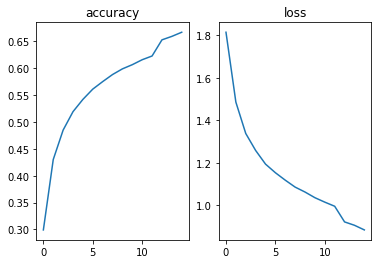

In [ ]:
plt.subplot(1,2,1)
plt.plot(list(range(15)), history.history['accuracy'])
plt.title("accuracy")
plt.subplot(1,2,2)
plt.plot(list(range(15)), history.history['loss'])
plt.title("loss")

# save model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
model.save("/content/drive/My Drive/Facial Exp/model_acc64.h5")

In [ ]:
classes = {i:j for j,i in train_generator.class_indices.items()}

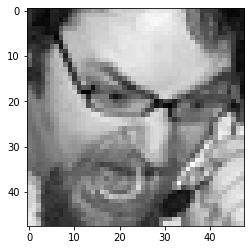

In [ ]:
img = cv2.resize(io.imread("/content/data/Project/test/angry/PrivateTest_10131363.jpg", as_gray=True), dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
plt.imshow(img, cmap='gray')
cls = model.predict(np.expand_dims(np.expand_dims(img, axis=-1), axis=0))

In [ ]:
classes[np.argmax(cls[0])]

'angry'